# DPO Inference - Before vs After Comparison

Compare model responses before and after DPO preference tuning.

In [1]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../visual_instruction_tuning')

import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from tokenizers import Tokenizer
import tomllib

from visual_instruction_tuning.model import create_instruct_vlm, DEFAULT_CONFIG, DEFAULT_LLM_CKPT, DEFAULT_VLM_CKPT

# Paths
PROJECT_ROOT = Path('../..').resolve()
PRE_DPO_CKPT = PROJECT_ROOT / 'visual_instruction_tuning' / 'checkpoints' / 'best_instruct.pt'
POST_DPO_CKPT = PROJECT_ROOT / 'preference_tuning' / 'checkpoints' / 'best_dpo.pt'
TOKENIZER_PATH = PROJECT_ROOT / 'visual_instruction_tuning' / 'bpe_tokenizer_with_image_tag.json'
COCO_DIR = Path('/home/smedar/fiftyone/coco-2017')

print(f"Pre-DPO checkpoint: {PRE_DPO_CKPT.exists()}")
print(f"Post-DPO checkpoint: {POST_DPO_CKPT.exists()}")

Pre-DPO checkpoint: True
Post-DPO checkpoint: True


## Load Config and Tokenizer

In [2]:
# Load config
with open(DEFAULT_CONFIG, 'rb') as f:
    cfg = tomllib.load(f)

# Load tokenizer
tokenizer = Tokenizer.from_file(str(TOKENIZER_PATH))
print(f"Vocab size: {tokenizer.get_vocab_size()}")

# Special tokens
IMAGE_TOKEN_ID = tokenizer.token_to_id('<image>')
EOS_TOKEN_ID = tokenizer.token_to_id('</s>')
PAD_TOKEN_ID = tokenizer.token_to_id('<pad>') or 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Vocab size: 32001
Device: cuda


## Load Both Models

In [3]:
def load_model(checkpoint_path, name="model"):
    """Load model from checkpoint."""
    print(f"\nLoading {name}...")
    model = create_instruct_vlm(cfg, str(DEFAULT_LLM_CKPT), str(DEFAULT_VLM_CKPT))
    
    ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    model.load_state_dict(ckpt['model_state_dict'])
    
    # Print checkpoint info
    if 'val_loss' in ckpt:
        print(f"  Val loss: {ckpt['val_loss']:.4f}")
    if 'val_acc' in ckpt:
        print(f"  Val acc: {ckpt['val_acc']:.2f}%")
    
    model = model.to(device)
    model.eval()
    return model

# Load pre-DPO (instruction tuned)
model_pre = load_model(PRE_DPO_CKPT, "Pre-DPO (Instruction Tuned)")

# Load post-DPO (preference tuned)
model_post = load_model(POST_DPO_CKPT, "Post-DPO (Preference Tuned)")

print("\nBoth models loaded!")


Loading Pre-DPO (Instruction Tuned)...
Loading LLM checkpoint from: /home/smedar/code_files/llama4-from-scratch/text_pretraining/checkpoints/best.pt
LLM checkpoint loaded successfully
Loading VLM checkpoint from: /home/smedar/code_files/llama4-from-scratch/vision_language_alignment/checkpoints/best_vlm.pt
VLM checkpoint loaded (val_loss: 3.2270)
  Val loss: 1.6852

Loading Post-DPO (Preference Tuned)...
Loading LLM checkpoint from: /home/smedar/code_files/llama4-from-scratch/text_pretraining/checkpoints/best.pt
LLM checkpoint loaded successfully
Loading VLM checkpoint from: /home/smedar/code_files/llama4-from-scratch/vision_language_alignment/checkpoints/best_vlm.pt
VLM checkpoint loaded (val_loss: 3.2270)
  Val loss: 0.6468
  Val acc: 0.65%

Both models loaded!


## Inference Functions

In [4]:
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


def load_image(image_path):
    """Load and preprocess an image."""
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def prepare_input(image, question):
    """Prepare image and question for the model."""
    img_tensor = image_transform(image).unsqueeze(0).to(device)
    
    prompt = f" USER: {question} ASSISTANT:"
    tokens = tokenizer.encode(prompt).ids
    input_ids = [IMAGE_TOKEN_ID] + tokens
    input_ids = torch.tensor([input_ids], dtype=torch.long, device=device)
    
    return img_tensor, input_ids


@torch.no_grad()
def generate(model, image, question, max_new_tokens=100, temperature=0.7, top_p=0.9, repetition_penalty=1.2):
    """Generate response from a model."""
    img_tensor, input_ids = prepare_input(image, question)
    generated_ids = []
    
    for _ in range(max_new_tokens):
        logits = model(img_tensor, input_ids)
        next_logits = logits[0, -1, :].clone()
        
        # Apply repetition penalty BEFORE sampling
        if len(generated_ids) > 0 and repetition_penalty != 1.0:
            for token_id in set(generated_ids[-20:]):  # penalize last 20 tokens
                if next_logits[token_id] > 0:
                    next_logits[token_id] /= repetition_penalty
                else:
                    next_logits[token_id] *= repetition_penalty
        
        if temperature > 0:
            next_logits = next_logits / temperature
            sorted_logits, sorted_indices = torch.sort(next_logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = False
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            next_logits[indices_to_remove] = float('-inf')
            probs = torch.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        else:
            next_token = next_logits.argmax().item()
        
        if next_token == EOS_TOKEN_ID:
            break

        generated_ids.append(next_token)
        next_token_tensor = torch.tensor([[next_token]], device=device)
        input_ids = torch.cat([input_ids, next_token_tensor], dim=1)
    
    return tokenizer.decode(generated_ids).strip()

## Compare Function

In [5]:
def compare(image_path, question, show_image=True, temperature=0.7, max_new_tokens=100):
    """
    Compare pre-DPO and post-DPO responses side-by-side.
    """
    image = load_image(image_path)
    
    if show_image:
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Q: {question}")
        plt.show()
    
    # Generate from both models
    print(f"Q: {question}")
    print("="*60)
    
    response_pre = generate(model_pre, image, question, 
                           temperature=temperature, max_new_tokens=max_new_tokens)
    print(f"PRE-DPO:  {response_pre}")
    print("-"*60)
    
    response_post = generate(model_post, image, question,
                            temperature=temperature, max_new_tokens=max_new_tokens)
    print(f"POST-DPO: {response_post}")
    print("="*60)
    
    return response_pre, response_post


def compare_greedy(image_path, question, show_image=True, max_new_tokens=100):
    """Compare with greedy decoding (deterministic)."""
    return compare(image_path, question, show_image=show_image, 
                  temperature=0, max_new_tokens=max_new_tokens)

## Find Sample Images

In [6]:
train_dir = COCO_DIR / 'train' / 'data'
val_dir = COCO_DIR / 'validation' / 'data'

if train_dir.exists():
    image_dir = train_dir
elif val_dir.exists():
    image_dir = val_dir
else:
    image_dir = COCO_DIR / 'train2017'

sample_images = list(image_dir.glob('*.jpg'))[:20]
print(f"Found {len(sample_images)} sample images")

Found 20 sample images


## Test: Basic Description

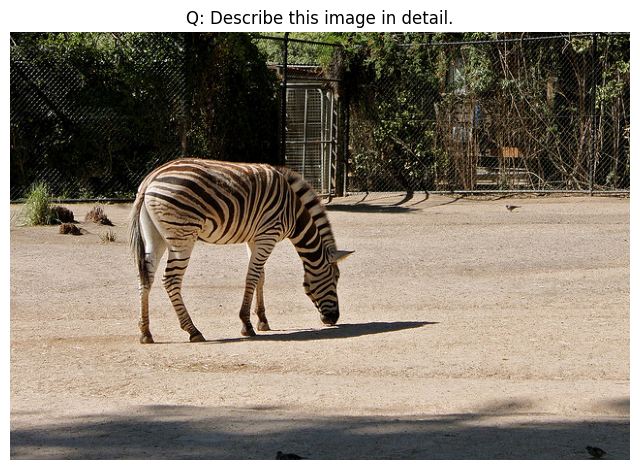

Q: Describe this image in detail.
PRE-DPO:  The image depicts a zebra walking along a dirt path, with its head up against the wall. The zebra appears to be standing in front of a large tree, which is located near the center of the image.

There are several cars parked along the path, including one close to the zebra and another further away. There are a few cars visible in the background, one near the top right corner of the image and another further down the road. Additionally, there are a few
------------------------------------------------------------
POST-DPO: The image features a zebra walking in a dirt area near a fence. A group of zebras is present in the background, creating an interesting scene that captures the zebra's curiosity and natural instincts. There are several zebras in various positions throughout the scene, some close to each other and others scattered across different areas of the area.

The zebras are in close proximity to each other, creating a sense of edge and

('The image depicts a zebra walking along a dirt path, with its head up against the wall. The zebra appears to be standing in front of a large tree, which is located near the center of the image.\n\nThere are several cars parked along the path, including one close to the zebra and another further away. There are a few cars visible in the background, one near the top right corner of the image and another further down the road. Additionally, there are a few',
 "The image features a zebra walking in a dirt area near a fence. A group of zebras is present in the background, creating an interesting scene that captures the zebra's curiosity and natural instincts. There are several zebras in various positions throughout the scene, some close to each other and others scattered across different areas of the area.\n\nThe zebras are in close proximity to each other, creating a sense of edge and interaction within the enclosure. The presence of trees in the background adds")

In [7]:
compare(sample_images[0], "Describe this image in detail.")

## Test: Greedy Decoding

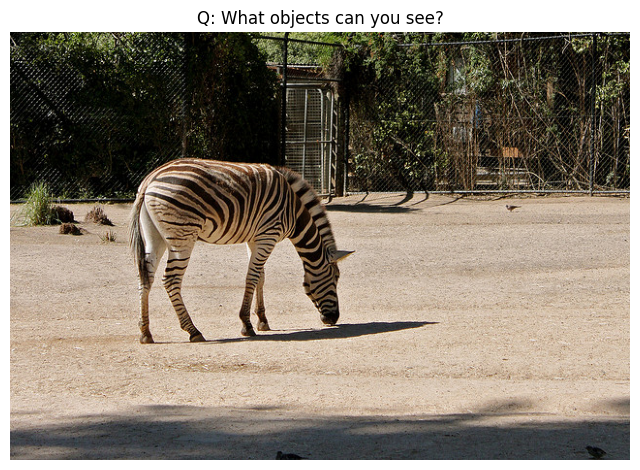

Q: What objects can you see?
PRE-DPO:  In the image, there is a zebra and a tree in a fenced-off area. The zebra is standing next to the tree, and there are two other animals in the background. The grassy area is also covered with a tree, which could be part of the enclosure or a zoo. The presence of the tree suggests that it might have been used for various purposes, such as providing shade or shelter from harsh weather conditions.
------------------------------------------------------------
POST-DPO: In the image, there is a dirt field with trees in the background. The zebras are standing near a fence and some trees, which suggests that they might be in an enclosure or a zoo. The presence of the fence and trees indicates that this area is likely part of an enclosure or a zoo. The zebras are standing near the fence and trees, which indicates that they might be in a zoo or wildlife park.


('In the image, there is a zebra and a tree in a fenced-off area. The zebra is standing next to the tree, and there are two other animals in the background. The grassy area is also covered with a tree, which could be part of the enclosure or a zoo. The presence of the tree suggests that it might have been used for various purposes, such as providing shade or shelter from harsh weather conditions.',
 'In the image, there is a dirt field with trees in the background. The zebras are standing near a fence and some trees, which suggests that they might be in an enclosure or a zoo. The presence of the fence and trees indicates that this area is likely part of an enclosure or a zoo. The zebras are standing near the fence and trees, which indicates that they might be in a zoo or wildlife park.')

In [8]:
compare_greedy(sample_images[0], "What objects can you see?")

## Test: Multiple Images


############################################################
IMAGE 1
############################################################



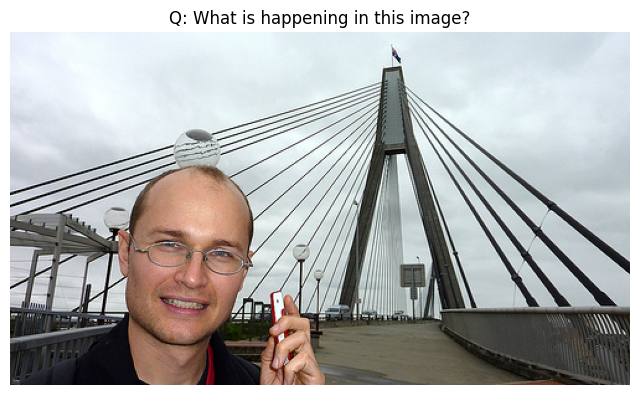

Q: What is happening in this image?
PRE-DPO:  The image features a man standing in front of a large, tall building with a clock on it. He is wearing glasses and appears to be looking at something in the distance. The man seems to be enjoying his time, possibly taking a break from work or other activities.

In the background, there are several cars parked along the street, and a truck is visible in the distance. There are also two people standing near the building, possibly waiting for their turn to work or socialize.
------------------------------------------------------------
POST-DPO: In the image, a man is smiling and wearing glasses, possibly wearing glasses. He appears to be in an outdoor setting with a large structure or structure nearby. The scene is set near a bridge, which suggests that the area might be part of an urban or urban setting.

############################################################
IMAGE 2
############################################################



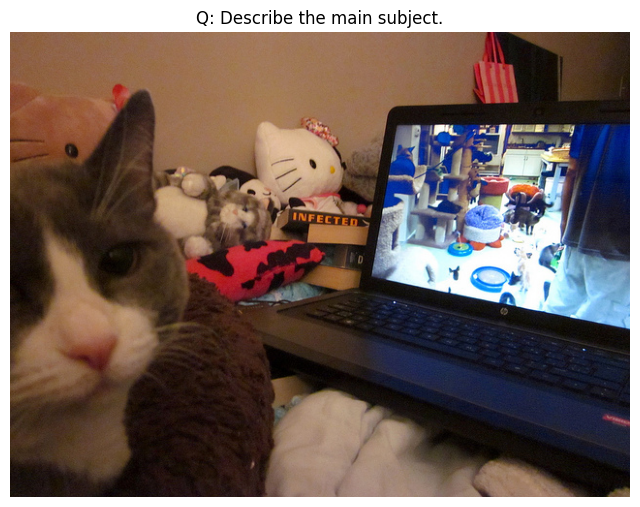

Q: Describe the main subject.
PRE-DPO:  The main subject of the image is a cat sitting on top of a laptop computer. The cat appears to be curious and may have just finished using the laptop. The cat is sitting on top of a laptop, which could be a comfortable and cozy spot for the cat to rest.
------------------------------------------------------------
POST-DPO: The main subject of the image is a cat sitting on top of a laptop computer. The cat appears to be a mix of cats and people, possibly enjoying the warmth and attention from the laptop. The cat is positioned near a desk with various objects, including books, a mouse, and some other items. The cat appears to be a close-up shot of the cat, giving it a sense of depth and interest.

############################################################
IMAGE 3
############################################################



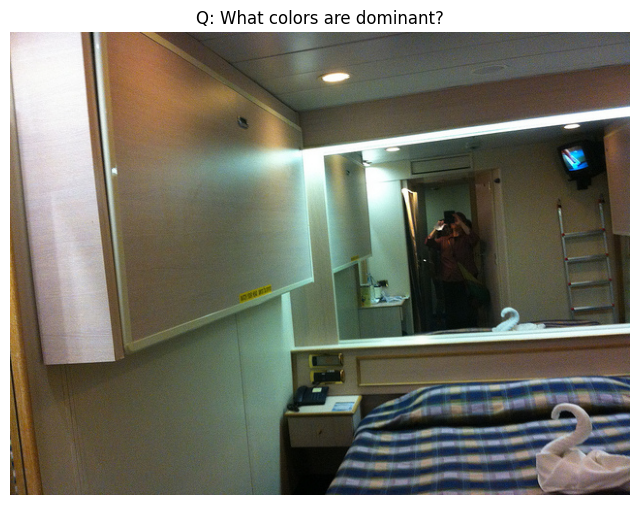

Q: What colors are dominant?
PRE-DPO:  The dominant colors in the bedroom are white and blue. These colors are typically associated with nature, such as the sun, the sky, or the sun. The white color is often associated with nature and can be seen as a symbol of good weather or a sense of tranquility. The blue color is often associated with relaxation, comfort, and the feeling of being in a comfortable environment.
------------------------------------------------------------
POST-DPO: In the image, there is a woman and a man sitting in a bathroom. The presence of these colors suggests that the room might be designed for various activities, such as taking a break from work or studying.


In [9]:
questions = [
    "What is happening in this image?",
    "Describe the main subject.",
    "What colors are dominant?"
]

for i, img_path in enumerate(sample_images[1:4]):
    print(f"\n{'#'*60}")
    print(f"IMAGE {i+1}")
    print(f"{'#'*60}\n")
    compare_greedy(img_path, questions[i % len(questions)])

## Batch Evaluation

In [10]:
def evaluate_batch(image_paths, questions, temperature=0):
    """
    Evaluate multiple image-question pairs.
    Returns results as a list of dicts.
    """
    results = []
    
    for img_path, question in zip(image_paths, questions):
        image = load_image(img_path)
        
        pre = generate(model_pre, image, question, temperature=temperature)
        post = generate(model_post, image, question, temperature=temperature)
        
        results.append({
            'image': img_path.name,
            'question': question,
            'pre_dpo': pre,
            'post_dpo': post,
        })
        print(f"Processed: {img_path.name}")
    
    return results

# Example: evaluate 5 images with same question
test_images = sample_images[:5]
test_questions = ["What do you see in this image?"] * 5

results = evaluate_batch(test_images, test_questions)

Processed: 000000210458.jpg
Processed: 000000446058.jpg
Processed: 000000190387.jpg
Processed: 000000345557.jpg
Processed: 000000149467.jpg


In [11]:
# Display results
for r in results:
    print(f"\n{'='*60}")
    print(f"Image: {r['image']}")
    print(f"Q: {r['question']}")
    print(f"PRE:  {r['pre_dpo']}")
    print(f"POST: {r['post_dpo']}")


Image: 000000210458.jpg
Q: What do you see in this image?
PRE:  The image features a zebra standing in an open field, surrounded by trees. The zebra is positioned towards the left side of the image, while the other two are in the middle. The scene appears to be taking place in a zoo or wildlife park, as there are trees nearby.

In the background, there is a fence visible, which could be used for security purposes or to keep the zebra within its enclosure. The scene captures a moment of natural beauty and wildlife, showcasing the
POST: The image captures a close-up view of a zebra standing in an enclosure. The zebra is positioned near a fence, which suggests that it might be a zoo or wildlife park. The zebra is standing in an enclosure, which suggests that it might be a zoo or wildlife park. The zebra's presence in the enclosure adds an interesting element to the scene, as it is a large and unique animal that stands out from typical zebras.

Image: 000000446058.jpg
Q: What do you see i

## Use Single Model (Post-DPO)

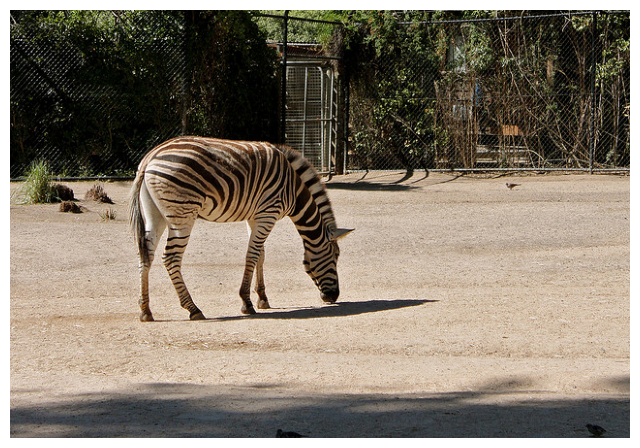

Q: What's in this image?
A: The image captures a scene of a group of zebras standing near a fence. There are multiple zebras present in the background, some close together and others in the same area. The scene gives off a sense of life for these animals, as zebras are often found in close proximity to each other and within a group. The presence of the fence adds an interesting visual element to the scene, showcasing the animals' social interactions and interaction in their environment.


"The image captures a scene of a group of zebras standing near a fence. There are multiple zebras present in the background, some close together and others in the same area. The scene gives off a sense of life for these animals, as zebras are often found in close proximity to each other and within a group. The presence of the fence adds an interesting visual element to the scene, showcasing the animals' social interactions and interaction in their environment."

In [12]:
def ask(image_path, question, show_image=True, temperature=0.7, max_new_tokens=100):
    """Ask using the post-DPO model only."""
    image = load_image(image_path)
    
    if show_image:
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    
    response = generate(model_post, image, question,
                       temperature=temperature, max_new_tokens=max_new_tokens)
    print(f"Q: {question}")
    print(f"A: {response}")
    return response

# Test
ask(sample_images[0], "What's in this image?")

## Custom Image

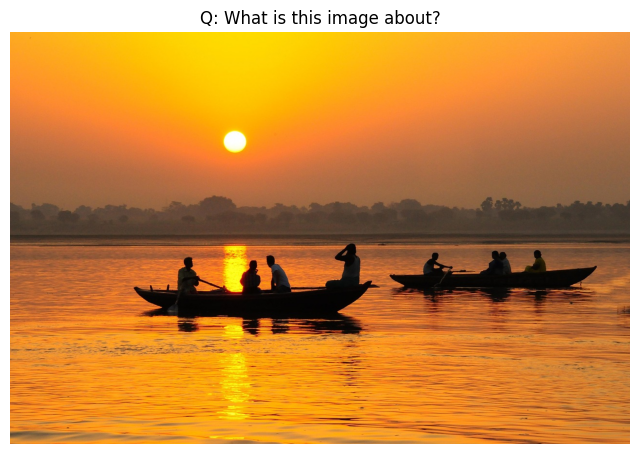

Q: What is this image about?
PRE-DPO:  The image depicts a group of people on the water near a body of water, likely a river or a lake. There are several boats visible in the scene, some close to each other and others further away. The people seem to be enjoying a day at the lake, as there are two men riding on top of the boat.

In addition to the boats, there is a car parked further back on the water. The overall atmosphere appears lively and bustling as people enjoy their time near the
------------------------------------------------------------
POST-DPO: The image captures a beautiful scene of several boats and boats, where some are being used as a driver in a boat. The presence of the large group of boats and their impact on the boats creates an interesting visual image.

The scene conveys a sense of adventure and adventure, as the boats are on the water, with some people riding them. The presence of the boat and the overall scene captures a moment of adventure and excitement, as p

('The image depicts a group of people on the water near a body of water, likely a river or a lake. There are several boats visible in the scene, some close to each other and others further away. The people seem to be enjoying a day at the lake, as there are two men riding on top of the boat.\n\nIn addition to the boats, there is a car parked further back on the water. The overall atmosphere appears lively and bustling as people enjoy their time near the',
 'The image captures a beautiful scene of several boats and boats, where some are being used as a driver in a boat. The presence of the large group of boats and their impact on the boats creates an interesting visual image.\n\nThe scene conveys a sense of adventure and adventure, as the boats are on the water, with some people riding them. The presence of the boat and the overall scene captures a moment of adventure and excitement, as people are enjoying themselves in the water.')

In [13]:
# Test with your own image:
compare('/home/smedar/code_files/llama4-from-scratch/vision_language_alignment/notebooks/sample_image.png', 'What is this image about?')